> # Image Classification
> This project implements a `Convolutional Neural Network (CNN)` using `PyTorch` to classify images of dogs and cats. The model is trained on a dataset of pet images and achieves high accuracy in distinguishing between the two classes through deep learning techniques.

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Setting GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

> ## Building a Data Loading Class
> This class provides an efficient data loading solution for the Dog vs Cat classification project, featuring automated folder-based data loading and comprehensive `data augmentation` techniques to improve model generalization.

In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        # Define the paths to your train and test directories
        self.train_dir = '/kaggle/input/dogs-vs-cats/train'
        self.test_dir = '/kaggle/input/dogs-vs-cats/test'

        # Data Augumentation
        train_transforms = transforms.Compose([
            transforms.CenterCrop(256), # Crop to center 256*256
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ResNet Normalization parameters

            # You can perform more transformation
                # transforms.RandomResizedCrop(256),     
                # transforms.RandomHorizontalFlip(),
        ])
    
        test_transforms = transforms.Compose([
            transforms.Resize(256), # Resize shorter side to 256
            transforms.CenterCrop(256), # Then crop to 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Create the training dataset
        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=train_transforms)
        
        # Create the testing dataset
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=test_transforms)

    def __len__(self):
        return len(self.train_dataset) + len(self.test_dataset)

    def __getitem__(self, index):
        return self.train_dataset[index]

In [4]:
# Creating CustomDataset object
dataset = CustomDataset()

In [5]:
# Create the training dataloader
train_loader = DataLoader(
    dataset=dataset.train_dataset,
    batch_size=32,
    shuffle=True,  # Shuffle the training data at the beginning of each epoch
    num_workers=4,  # Use 4 worker processes to load data in parallel - max available till now
    pin_memory=True
)

# Create the testing dataloader
test_loader = DataLoader(
    dataset=dataset.test_dataset,
    batch_size=32,
    shuffle=False, # No need to shuffle the testing data
    num_workers=4,
    pin_memory=True
)

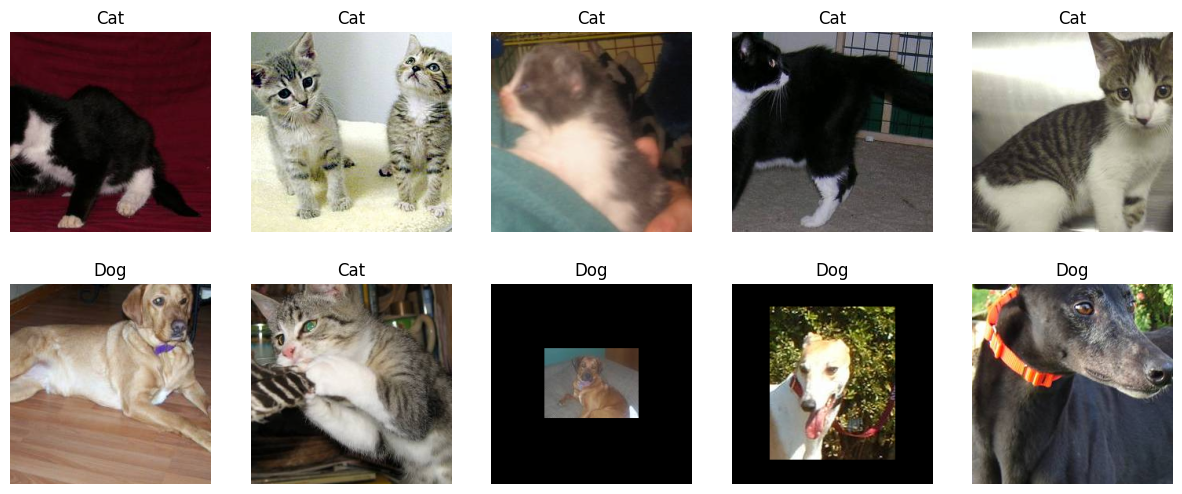

In [6]:
# Create the figure and subplots ONCE outside the loop
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

# Pre-define normalization parameters
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for input_features, input_labels in train_loader:
    for i in range(2):
        for j in range(5):
            # Get random image from dataset
            idx = np.random.randint(1, 32)
            image_tensor = input_features[idx]
            
            # Convert from PyTorch format (C, H, W) to matplotlib format (H, W, C)
            image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
            
            # Denormalize the image
            image_np = image_np * std + mean
            image_np = np.clip(image_np, 0, 1)
            
            # Display image in the correct subplot
            ax[i, j].imshow(image_np)
            ax[i, j].axis('off')  # Remove axes for each subplot
            ax[i, j].set_title('Cat' if input_labels[idx] == 0 else 'Dog')  # Remove title for cleaner look

    break
    # Apply tight layout and show ONCE after all images are processed
    plt.tight_layout()
    plt.show()

In [7]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.features = nn.Sequential(
            # Block 1: Basic edge detection
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2: Texture detection  
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3: Pattern recognition
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4: Object detection
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 5: High-level features
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),  # Simplified classifier
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # 2 classes for CrossEntropyLoss
        )

    def forward(self, X_train):
        model = self.features(X_train)
        model = self.classifier(model)
        return model

In [8]:
# Model setup
model = CustomModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()  # Instead of BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
for epoch in range(10):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        # Move the current batch to GPU
        X_train = batch_features.to(device)
        y_train = batch_labels.to(device)

        # Forward Propagation
        outputs = model(X_train)  # ✅ Keep raw logits

        # Loss Calculation
        loss = criterion(outputs, y_train)  # ✅ CrossEntropyLoss handles this

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()

        # Update Gradients
        optimizer.step()

        # Loss Addition
        total_epoch_loss = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.646928307056427
Epoch: 2 , Loss: 0.5338943243026734
Epoch: 3 , Loss: 0.49096029591560364
Epoch: 4 , Loss: 0.4442851628303528
Epoch: 5 , Loss: 0.398352043390274
Epoch: 6 , Loss: 0.35323426733016966
Epoch: 7 , Loss: 0.3162427542567253
Epoch: 8 , Loss: 0.28996319180727004
Epoch: 9 , Loss: 0.24870561157763005
Epoch: 10 , Loss: 0.2282200810313225


In [10]:
model.eval()

CustomModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [11]:
import torch
from torchmetrics.classification import MulticlassAccuracy

# 1. Initialize the metric for 2 classes
metric = MulticlassAccuracy(num_classes=2).to(device)

# evaluation on test data
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move data to the same device as the metric
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    
        # Get model predictions (logits)
        outputs = model(batch_features)  # Shape: [32, 2]
    
        # MulticlassAccuracy handles logits directly
        metric.update(outputs, batch_labels)

# 3. Compute the final accuracy over all batches after the loop
total_accuracy = metric.compute()

print(f"Test Accuracy: {total_accuracy:.4f}")

# Optional: Reset the metric if you plan to use it again
metric.reset()

Test Accuracy: 0.9138


In [12]:
import torch
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MulticlassPrecision, 
    MulticlassRecall, 
    MulticlassF1Score,
    MulticlassConfusionMatrix
)

# Initialize all metrics for 2 classes
accuracy = MulticlassAccuracy(num_classes=2).to(device)
precision = MulticlassPrecision(num_classes=2, average='macro').to(device)  # macro avg
recall = MulticlassRecall(num_classes=2, average='macro').to(device)
f1 = MulticlassF1Score(num_classes=2, average='macro').to(device)
confusion_matrix = MulticlassConfusionMatrix(num_classes=2).to(device)

# Set model to evaluation mode
model.eval()

# Evaluation on test data
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move data to device
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        # Get model predictions (logits)
        outputs = model(batch_features)  # Shape: [batch_size, 2]
        
        # Update all metrics with logits and true labels
        accuracy.update(outputs, batch_labels)
        precision.update(outputs, batch_labels)
        recall.update(outputs, batch_labels)
        f1.update(outputs, batch_labels)
        confusion_matrix.update(outputs, batch_labels)

# Compute final results
test_accuracy = accuracy.compute()
test_precision = precision.compute()
test_recall = recall.compute()
test_f1 = f1.compute()
conf_matrix = confusion_matrix.compute()

# Print results
print("=" * 50)
print("TEST SET EVALUATION RESULTS")
print("=" * 50)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix.cpu().numpy())

TEST SET EVALUATION RESULTS
Accuracy:  0.9138
Precision: 0.9173
Recall:    0.9138
F1-Score:  0.9136

Confusion Matrix:
[[2170  330]
 [ 101 2399]]


> ## Overall Performance Summary
> Your CNN model demonstrates strong performance with an accuracy of 86.52%, which is significantly better than random guessing (50%) and indicates successful learning of distinguishing features between dogs and cats.